In [25]:
from typing import Any
import pandas as pd
from sklearn.model_selection import train_test_split
from sklift.datasets import fetch_hillstrom
from sklift.metrics import uplift_at_k, uplift_by_percentile, weighted_average_uplift
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier
from category_encoders import CatBoostEncoder

In [26]:
def get_data() -> tuple[Any, Any, Any]:
	# получаем датасет
	dataset = fetch_hillstrom(target_col='visit')
	dataset, target, treatment = dataset['data'], dataset['target'], dataset['treatment']
	# выбираем два сегмента
	dataset = dataset[treatment != 'Mens E-Mail']
	target = target[treatment != 'Mens E-Mail']
	treatment = treatment[treatment != 'Mens E-Mail'].map({
		'Womens E-Mail': 1,
		'No E-Mail':     0
	})

	return dataset, target, treatment

In [27]:
dataset, target, treatment = get_data()

data_train_index = pd.read_csv('../data/data_train_index.csv')
data_test_index = pd.read_csv('../data/data_test_index.csv')
treatment_train_index = pd.read_csv('../data/treatment_train_index.csv')
treatment_test_index = pd.read_csv('../data/treatment_test_index.csv')
target_train_index = pd.read_csv('../data/target_train_index.csv')
target_test_index = pd.read_csv('../data/target_test_index.csv')

# фиксируем выборки, чтобы результат работы ML был предсказуем
data_train = dataset.loc[data_train_index['0']]
data_test = dataset.loc[data_test_index['0']]
treatment_train = treatment.loc[treatment_train_index['0']]
treatment_test = treatment.loc[treatment_test_index['0']]
target_train = target.loc[target_train_index['0']]
target_test = target.loc[target_test_index['0']]

In [28]:
models_results = {
    'approach': [],
    'uplift@30%': []
}

## Single model

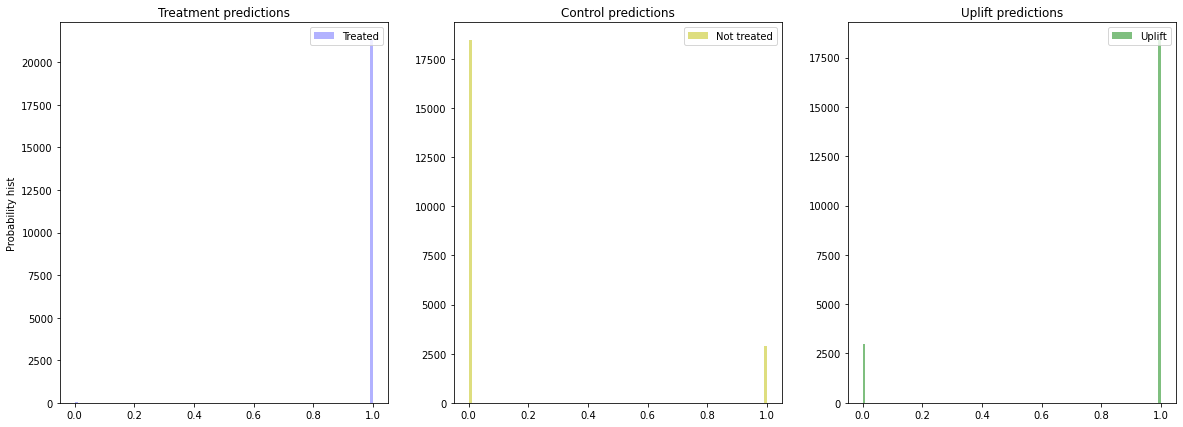

In [44]:
# cbr = CatBoostClassifier(iterations=500, task_type="GPU", random_state=42, silent=True)
cbr = CatBoostClassifier()
cbr.load_model('sm_cbc.cbm')
sm = SoloModel(cbr)
# sm.estimator.load_model('model.cbm')
# sm = sm.fit(data_train, treatment_train, target_train, estimator_fit_params={'cat_features': ['womens', 'mens','channel', 'zip_code', 'history_segment', 'newbie']})

uplift_sm = sm.predict(data_test)

sm_score = uplift_at_k(y_true=target_test, uplift=uplift_sm, treatment=treatment_test, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [30]:
sm.estimator.save_model('models/sm_cbc.cbm')

P:\uplift_lab\venv\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0452'}, xlabel='Percentile', ylabel='Uplift = treatment response rate - control response rate'>

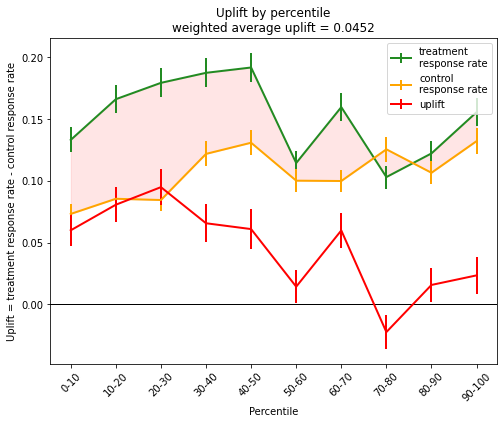

In [31]:
from sklift.viz import plot_uplift_by_percentile

plot_uplift_by_percentile(target_test, uplift_sm, treatment_test)

In [32]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,treatment,23.090004
1,channel,19.284459
2,zip_code,15.911562
3,history_segment,13.699184
4,history,13.131164
5,recency,7.301571
6,mens,3.429339
7,womens,3.394266
8,newbie,0.758451


## Class transform

In [33]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=500, task_type='GPU', random_state=42, silent=True))
ct.fit(data_train, target_train, treatment_train, estimator_fit_params={'cat_features': ['womens', 'mens','channel', 'zip_code', 'history_segment', 'newbie']})

uplift_ct = ct.predict(data_test)

ct_score = uplift_at_k(y_true=target_test, uplift=uplift_ct, treatment=treatment_test, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)


In [34]:
ct.estimator.save_model('models/ct_cbc.cbm')

## Two independent models

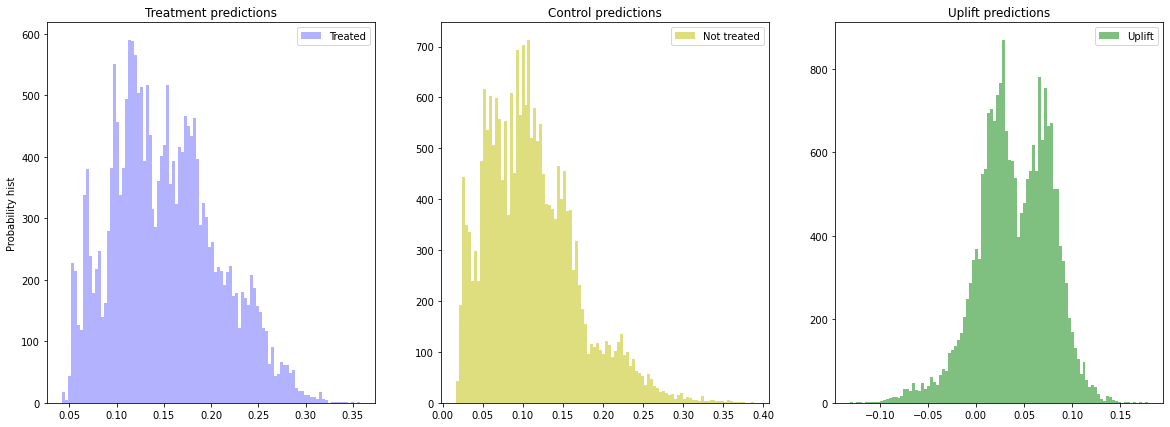

In [35]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=500, task_type='GPU', random_state=42, silent=True),
    estimator_ctrl=CatBoostClassifier(iterations=500, task_type='GPU', random_state=42, silent=True),
    method='vanilla'
)
tm.fit(
    data_train, target_train, treatment_train,
    estimator_trmnt_fit_params={'cat_features': ['womens', 'mens','channel', 'zip_code', 'history_segment', 'newbie']},
    estimator_ctrl_fit_params={'cat_features': ['womens', 'mens','channel', 'zip_code', 'history_segment', 'newbie']}
)

uplift_tm = tm.predict(data_test)

tm_score = uplift_at_k(y_true=target_test, uplift=uplift_tm, treatment=treatment_test, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [36]:
tm.estimator_ctrl.save_model('models/tm_ctrl_cbc.cbm')
tm.estimator_trmnt.save_model('models/tm_trmnt_cbc.cbm')

## Two dependend models

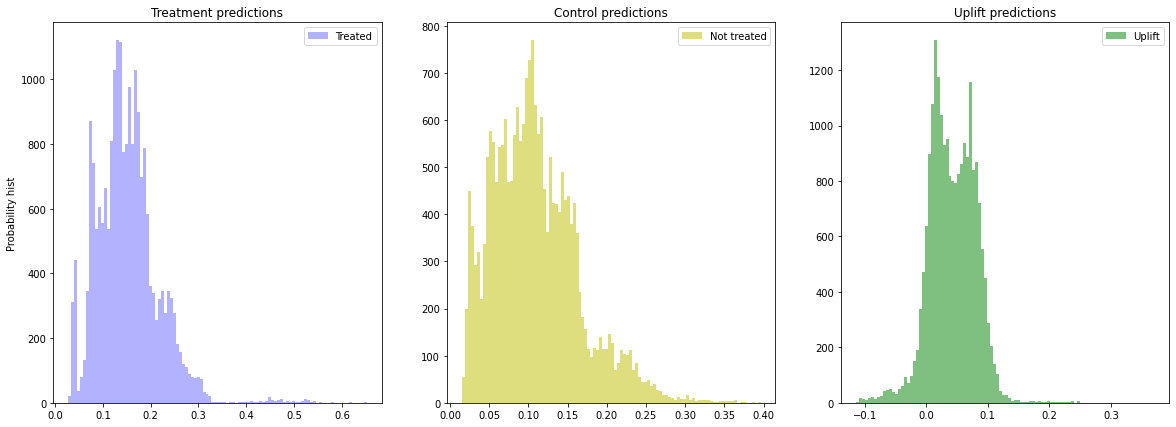

In [37]:
tm_ctrl = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=500, task_type='GPU', random_state=42, silent=True),
    estimator_ctrl=CatBoostClassifier(iterations=500, task_type='GPU', random_state=42, silent=True),
    method='ddr_control'
)

tm_ctrl = tm_ctrl.fit(
    data_train, target_train, treatment_train,
    estimator_trmnt_fit_params={'cat_features': ['womens', 'mens','channel', 'zip_code', 'history_segment', 'newbie']},
    estimator_ctrl_fit_params={'cat_features': ['womens', 'mens','channel', 'zip_code', 'history_segment', 'newbie']}
)

uplift_tm_ctrl = tm_ctrl.predict(data_test)

tm_ctrl_score = uplift_at_k(y_true=target_test, uplift=uplift_tm_ctrl, treatment=treatment_test, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_ddr_control')
models_results['uplift@30%'].append(tm_ctrl_score)

plot_uplift_preds(trmnt_preds=tm_ctrl.trmnt_preds_, ctrl_preds=tm_ctrl.ctrl_preds_);

In [38]:
tm.estimator_ctrl.save_model('models/tm_dependend_ctrl_cbc.cbm')
tm.estimator_trmnt.save_model('models/tm_dependend_trmnt_cbc.cbm')

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline

pipeline_ctrl = make_pipeline(
    OrdinalEncoder(categories=['channel', 'zip_code', 'history_segment']),
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
)

pipeline_trtmnt = make_pipeline(
    OrdinalEncoder(categories=['channel', 'zip_code', 'history_segment']),
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
)

tm_ctrl = TwoModels(
    estimator_trmnt=pipeline_ctrl,
    estimator_ctrl=pipeline_trtmnt,
    method='ddr_control'
)

tm_ctrl = tm_ctrl.fit(
    data_train, target_train, treatment_train
)

uplift_tm_ctrl = tm_ctrl.predict(data_test)

tm_ctrl_score = uplift_at_k(y_true=target_test, uplift=uplift_tm_ctrl, treatment=treatment_test, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_ddr_control')
models_results['uplift@30%'].append(tm_ctrl_score)

plot_uplift_preds(trmnt_preds=tm_ctrl.trmnt_preds_, ctrl_preds=tm_ctrl.ctrl_preds_);

ValueError: Shape mismatch: if categories is an array, it has to be of shape (n_features,).

In [39]:
pd.DataFrame([tm_ctrl.trmnt_preds_, uplift_tm_ctrl])

,0,1,2,3,4,5,6,7,8,9,...,21337,21338,21339,21340,21341,21342,21343,21344,21345,21346
0,0.187557,0.105281,0.161889,0.140160,0.468606,0.172560,0.130849,0.079300,0.039731,0.114872,...,0.091512,0.254877,0.163009,0.089335,0.200761,0.215388,0.142818,0.231624,0.232737,0.143152
1,0.036023,0.028304,0.045443,0.069228,0.181322,0.113093,0.053770,0.000879,0.005583,0.026389,...,0.045846,0.089228,0.013675,-0.014415,0.111710,0.087185,0.035382,-0.003007,-0.011135,0.048037


## Results

In [40]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
0,SoloModel,0.077602
3,TwoModels_ddr_control,0.073417
2,TwoModels,0.073161
1,ClassTransformation,0.066895


P:\uplift_lab\venv\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


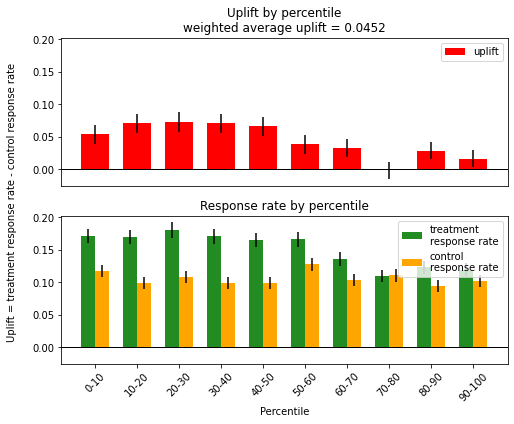

In [41]:
from sklift.viz import plot_uplift_by_percentile

# line plot
plot_uplift_by_percentile(target_test, uplift_ct, treatment_test, strategy='overall', kind='bar');